In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import sklearn.metrics as metrics

from sklearn.model_selection import TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1
# https://facebook.github.io/prophet/docs/quick_start.html#python-api

In [2]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/arifpras/forecastingDemand/main/20230126_database.csv')
data = pd.read_csv(url, sep=',', header=0, names=['month', 'incoming_bid_avg_sun', 'incoming_bid_avg_sbn', 'dpk_bankumum', 'dv_bankindonesia', 'vix_index', 'bfcius_bberg'])

# Data preparation
# ==============================================================================
data = data.rename(columns={'month': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
# data = data.rename(columns={'incoming_bid_avg_sun': 'incoming_bid_avg_sun'})
data = data.asfreq('MS')
data = data.sort_index()
data.head()

,incoming_bid_avg_sun,incoming_bid_avg_sbn,dpk_bankumum,dv_bankindonesia,vix_index,bfcius_bberg
date,,,,,,
2012-01-01,38.90175,38.901750,2770.57007,0,20.403182,-1.200591
2012-02-01,32.32425,18.457750,2763.94286,0,18.390000,-0.785571
2012-03-01,12.35250,8.043250,2825.97490,0,16.167273,-0.655591
2012-04-01,17.16300,11.396250,2841.36139,0,17.769524,-0.710952
2012-05-01,14.01525,8.320625,2908.95747,0,21.034783,-0.828000


In [10]:
# import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [11]:
# creating new dataframe from incoming_bid_avg_sun column
data_incbid = data[['incoming_bid_avg_sun']]
# inserting new column with dpk_bankumum values
data_incbid.loc[:,'dpk_bankumum_t-1'] = data[['dpk_bankumum']].shift()
# inserting new column with dv_bankindonesia values
data_incbid.loc[:,'dv_bankindonesia'] = data[['dv_bankindonesia']]
# inserting new column with dpk_bankumum values
data_incbid.loc[:,'vix_index'] = data[['vix_index']]

# dropping NAs
data_incbid = data_incbid.dropna()

data_incbid

/var/folders/9k/ff8g4yqn45s139zzyc224r800000gn/T/ipykernel_3558/2372373685.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_incbid.loc[:,'dpk_bankumum_t-1'] = data[['dpk_bankumum']].shift()
/var/folders/9k/ff8g4yqn45s139zzyc224r800000gn/T/ipykernel_3558/2372373685.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_incbid.loc[:,'dv_bankindonesia'] = data[['dv_bankindonesia']]
/var/folders/9k/ff8g4yqn45s139zzyc224r800000gn/T/ipykernel_3558/2372373685.py:8: SettingWithCopyWarning: 
A value is try

,incoming_bid_avg_sun,dpk_bankumum_t-1,dv_bankindonesia,vix_index
date,,,,
2012-02-01,32.32425,2770.57007,0,18.390000
2012-03-01,12.35250,2763.94286,0,16.167273
2012-04-01,17.16300,2825.97490,0,17.769524
2012-05-01,14.01525,2841.36139,0,21.034783
2012-06-01,13.74170,2908.95747,0,21.130952
...,...,...,...,...
2022-02-01,74.42140,7362.58000,1,25.574737
2022-03-01,52.09540,7384.39407,1,26.924783
2022-04-01,48.74260,7481.67500,1,24.232500


In [12]:
X_train = data_incbid[:'2021'].drop(['incoming_bid_avg_sun'], axis = 1)
y_train = data_incbid.loc[:'2021', 'incoming_bid_avg_sun']
X_test = data_incbid['2022'].drop(['incoming_bid_avg_sun'], axis = 1)
y_test = data_incbid.loc['2022', 'incoming_bid_avg_sun']

/var/folders/9k/ff8g4yqn45s139zzyc224r800000gn/T/ipykernel_3558/3489076382.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  X_test = data_incbid['2022'].drop(['incoming_bid_avg_sun'], axis = 1)


LR: -1.156213 (1.699404)
NN: -0.680299 (1.061231)
KNN: -0.622795 (0.949237)
RF: -0.698646 (0.697565)
SVR: -2.337011 (4.000870)


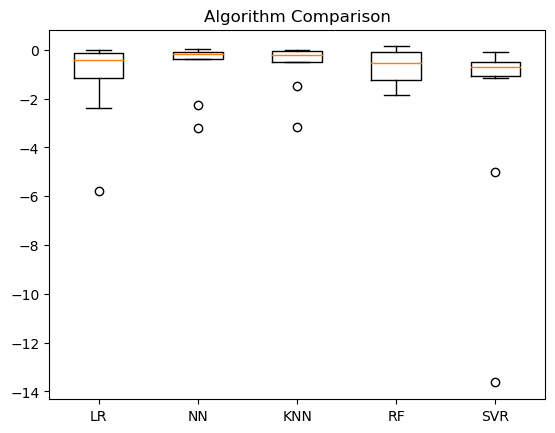

In [13]:
# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits=10)
    
 cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [14]:
from sklearn.metrics import make_scorer

def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

/Users/arifpras/miniconda3/envs/spyder-env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/arifpras/miniconda3/envs/spyder-env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/arifpras/miniconda3/envs/spyder-env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_f

In [16]:
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.1294
mean_squared_log_error:  0.2333
r2:  -1.0384
MAE:  20.4779
MSE:  661.466
RMSE:  25.719
